In [1]:
%pylab inline
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt
import time
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import copy

In [3]:
import csv

In [4]:
def ht(df, n = 5):
    print(df.shape)
    if len(df) <= 2*n:
        display(df)
    else:
        display(df.head(n).append(df.tail(n)))
def pf(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

In [5]:
pd.set_option('display.max_columns', 100)
# plt.rc('figure', figsize=(13, 7))
# plt.style.use('ggplot')

### Env Setup

In [6]:
SEED = 1966034587

In [7]:
import gym
from gym.envs.registration import register
from gym import utils
from gym.envs.toy_text import discrete
from six import StringIO

In [8]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [9]:
MAPS = {
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "20x20": [
        "SFFFFFFHHHFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFHFFFFFFFHHFFFFFFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFHFFFFFFFHHFF",
        "FFFFFHFFFFHHFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHHHHHHHFF",
        "HHHHFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFHHHFFFHHFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFHFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHFFFFFFFF",
        "FHHFFFHFFFFHFFFFFHFF",
        "FHHFHFHFFFFFFFFFFFFF",
        "FFFHFFFFFHFFFFHHFHFG"
    ]
}

In [10]:
class RewardingFrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, -1 for falling in a hole, and a small negative reward otherwise.
    The hole and step rewards are configurable when creating an instance of the problem.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4", rewarding=True, step_reward=-0.1, hole_reward=-1, is_slippery=True):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)
        self.step_reward = step_reward
        self.hole_reward = hole_reward
        self.rewarding = rewarding
        self.is_slippery = is_slippery

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == 0:  # left
                col = max(col - 1, 0)
            elif a == 1:  # down
                row = min(row + 1, nrow - 1)
            elif a == 2:  # right
                col = min(col + 1, ncol - 1)
            elif a == 3:  # up
                row = max(row - 1, 0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            if self.rewarding:
                                if newletter in b'FS':
                                    rew = self.step_reward
                                elif newletter == b'H':
                                    rew = self.hole_reward
                            li.append((0.85, newstate, rew, done))
                            for b in [(a + 1) % 4, (a + 2) % 4, (a + 3) % 4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                if self.rewarding:
                                    if newletter in b'FS':
                                        rew = self.step_reward
                                    elif newletter == b'H':
                                        rew = self.hole_reward
                                li.append((0.05, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            if self.rewarding:
                                if newletter in b'FS':
                                    rew = self.step_reward
                                elif newletter == b'H':
                                    rew = self.hole_reward
                            li.append((1.0, newstate, rew, done))

        super(RewardingFrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc) + "\n")

        if mode != 'human':
            return outfile

    def colors(self):
        return {
            b'S': 'green',
            b'F': 'skyblue',
            b'H': 'black',
            b'G': 'gold',
        }

    def directions(self):
        return {
            3: '⬆',
            2: '➡',
            1: '⬇',
            0: '⬅'
        }

    def new_instance(self):
        return RewardingFrozenLakeEnv(desc=self.desc, rewarding=self.rewarding, step_reward=self.step_reward,
                                      hole_reward=self.hole_reward, is_slippery=self.is_slippery)

In [11]:
register(
    id='RewardingFrozenLake8x8-v0',
    entry_point='__main__:RewardingFrozenLakeEnv',
    kwargs={'map_name': '8x8', 'rewarding': True, 'step_reward':-0.004, 'is_slippery': True}
)

In [12]:
env = gym.make('RewardingFrozenLake8x8-v0')

In [14]:
env.unwrapped.nS

64

In [15]:
env.unwrapped.nA

4

In [16]:
map_desc = env.unwrapped.desc

In [17]:
map_desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'H', b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'H', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'G']], dtype='|S1')

### Solver Setup

In [65]:
MAX_STEP_COUNT = 1000

In [18]:
from abc import ABC, abstractmethod

In [19]:
def one_step_lookahead(env, discount_factor, state, v):
    """
    Helper function to calculate the value for all action in a given state.

    Args:
        state: The state to consider (int)
        v: The value to use as an estimator, Vector of length env.nS

    Returns:
        A vector of length env.nA containing the expected value of each action.
    """
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[state][a]:
            A[a] += prob * (reward + discount_factor * v[next_state])
    return A


class BaseSolver(ABC):
    def __init__(self, verbose=False):
        self._verbose = verbose

    @abstractmethod
    def step(self):
        pass

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def has_converged(self):
        pass

    @abstractmethod
    def get_convergence(self):
        pass

    @abstractmethod
    def run_until_converged(self):
        pass

    @abstractmethod
    def get_environment(self):
        pass

    # Adapted from https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Policy%20Iteration%20Solution.ipynb
    def evaluate_policy(self, policy, discount_factor=1.0, max_steps=None, theta=0.00001):
        """
        Evaluate a policy given an environment and a full description of the environment's dynamics.

        Args:
            policy: The policy to evaluate
            max_steps: If not none, the number of iterations to run
            theta: We stop evaluation once our value function change is less than theta for all states.
            discount_factor: Gamma discount factor.

        Returns:
            Vector of length env.nS representing the value function.
        """
        env = self.get_environment()
        # Start with a random (all 0) value function
        V = np.zeros(env.nS)
        steps = 0
        while max_steps is None or steps < max_steps:
            delta = 0
            # For each state, perform a "full backup"
            for s in range(env.nS):
                v = 0
                # Look at the possible next actions
                for a, action_prob in enumerate(policy[s]):
                    # For each action, look at the possible next states...
                    for prob, next_state, reward, done in env.P[s][a]:
                        # Calculate the expected value
                        v += action_prob * prob * (reward + discount_factor * V[next_state])
                # How much our value function changed (across any states)
                delta = max(delta, np.abs(v - V[s]))
                V[s] = v
            # print('{} {} {}'.format(steps, delta, v))
            steps += 1
            # print("delta: {}, theta: {}".format(delta, theta))
            # Stop evaluating once our value function change is below a threshold
            if delta < theta:
                break

        return np.array(V)

    def render_policy(self, policy):
        env = self.get_environment()
        directions = env.directions()
        policy = np.reshape(np.argmax(policy, axis=1), env.desc.shape)

        for row in range(policy.shape[0]):
            for col in range(policy.shape[1]):
                print(directions[policy[row, col]] + ' ', end="")
            print("")

    def run_policy(self, policy, max_steps=1000, render_during=False):
        """
        Run through the given policy. This will reset the solver's environment before running.

        :param policy: The policy to run
        :param max_steps: The total number of steps to run. This helps prevent the agent getting "stuck"
        :param render_during: If true, render the env to stdout at each step
        :return: An ndarray of rewards for each step
        """
        policy = np.argmax(policy, axis=1)

        rewards = []

        # Clone the environment to get a fresh one
        env = self.get_environment().new_instance()
        state = env.reset()

        done = False
        steps = 0
        while not done and steps < max_steps:
            if render_during:
                env.render()

            action = policy[state]
            state, reward, done, info = env.step(action)
            rewards.append(reward)
            steps += 1

        if render_during:
            env.render()

        return np.array(rewards)

    def log(self, msg, *args):
        """
        If the learner has verbose set to true, log the message with the given parameters using string.format
        :param msg: The log message
        :param args: The arguments
        :return: None
        """
        print(msg.format(*args))

In [20]:
def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i, j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                                   path_effects.Normal()])

    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()

    return plt

def plot_value_map(title, v, map_desc, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, v.shape[1]), ylim=(0, v.shape[0]))
    font_size = 'x-large'
    if v.shape[1] > 16:
        font_size = 'small'

    v_min = np.min(v)
    v_max = np.max(v)
    bins = np.linspace(v_min, v_max, 100)
    v_red = np.digitize(v, bins)/100.0
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            value = np.round(v[i, j], 2)
            if len(str(value)) > 4:
                font_size = 'small'

    plt.title(title)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            y = v.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i, j]])
            ax.add_patch(p)

            value = np.round(v[i, j], 2)

            red = v_red[i, j]
            text2 = ax.text(x+0.5, y+0.5, value, size=font_size,
                            horizontalalignment='center', verticalalignment='center', color=(1.0, 1.0-red, 1.0-red))
            text2.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                   path_effects.Normal()])

    plt.axis('off')
    plt.xlim((0, v.shape[1]))
    plt.ylim((0, v.shape[0]))
    plt.tight_layout()

    return plt

import matplotlib.patheffects as path_effects

In [21]:
class ExperimentStats(object):
    def __init__(self):
        self.policies = list()
        self.vs = list()
        self.steps = list()
        self.step_times = list()
        self.rewards = list()
        self.deltas = list()
        self.converged_values = list()
        self.elapsed_time = 0
        self.optimal_policy = None

    def add(self, policy, v, step, step_time, reward, delta, converged):
        self.policies.append(policy)
        self.vs.append(v)
        self.steps.append(step)
        self.step_times.append(step_time)
        self.rewards.append(reward)
        self.deltas.append(delta)
        self.converged_values.append(converged)

    def to_csv(self, file_name):
        with open(file_name, 'w') as f:
            f.write("steps,time,reward,delta,converged\n")
            writer = csv.writer(f, delimiter=',')
            writer.writerows(zip(self.steps, self.step_times, self.rewards, self.deltas, self.converged_values))

    def pickle_results(self, file_name_base, map_shape, step_size=1, only_last=False):
        if only_last:
            policy = np.reshape(np.argmax(self.policies[-1], axis=1), map_shape)
            v = self.vs[-1].reshape(map_shape)
            file_name = file_name_base.format('Last')
            with open(file_name, 'wb') as f:
                pickle.dump({'policy': policy, 'v': v}, f)
        else:
            l = len(self.policies)
            if step_size == 1 and l > 20:
                step_size = math.floor(l/20.0)
            for i, policy in enumerate(self.policies):
                if i % step_size == 0 or i == l-1:
                    v = self.vs[i].reshape(map_shape)
                    file_name = file_name_base.format(i)
                    if i == l-1:
                        file_name = file_name_base.format('Last')
                    with open(file_name, 'wb') as f:
                        pickle.dump({'policy': np.reshape(np.argmax(policy, axis=1), map_shape), 'v': v}, f)

    def plot_policies_on_map(self, file_name_base, map_desc, color_map, direction_map, experiment, step_preamble,
                             env_readable_name, step_size=1, only_last=False):
        if only_last:
            policy = np.reshape(np.argmax(self.policies[-1], axis=1), map_desc.shape)
            v = self.vs[-1].reshape(map_desc.shape)

            policy_file_name = file_name_base.format('Policy', 'Last')
            value_file_name = file_name_base.format('Value', 'Last')
            title = '{}: {} - {} {}'.format(env_readable_name, experiment, 'Last', step_preamble)

            p = plot_policy_map(title, policy, map_desc, color_map, direction_map)
            p.show()
#             p.savefig(policy_file_name, format='png', dpi=150)
#             p.close()

            p = plot_value_map(title, v, map_desc, color_map)
            p.show()
#             p.savefig(value_file_name, format='png', dpi=150)
#             p.close()
        else:
            l = len(self.policies)
            if step_size == 1 and l > 20:
                step_size = math.floor(l/20.0)
            for i, policy in enumerate(self.policies):
                if i % step_size == 0 or i == l-1:
                    policy = np.reshape(np.argmax(policy, axis=1), map_desc.shape)
                    v = self.vs[i].reshape(map_desc.shape)

                    file_name = file_name_base.format('Policy', i)
                    value_file_name = file_name_base.format('Value', i)
                    if i == l-1:
                        file_name = file_name_base.format('Policy', 'Last')
                        value_file_name = file_name_base.format('Value', 'Last')

                    title = '{}: {} - {} {}'.format(env_readable_name, experiment, step_preamble, i)

                    p = plot_policy_map(title, policy, map_desc, color_map, direction_map)
                    p.show()
#                     p.savefig(file_name, format='png', dpi=150)
#                     p.close()

                    p = plot_value_map(title, v, map_desc, color_map)
                    p.show()
#                     p.savefig(value_file_name, format='png', dpi=150)
#                     p.close()
                    break

    def __str__(self):
        return 'policies: {}, vs: {}, steps: {}, step_times: {}, deltas: {}, converged_values: {}'.format(
            self.policies,
            self.vs,
            self.steps,
            self.step_times,
            self.deltas,
            self.converged_values
        )

In [22]:
class EvaluationStats(object):
    def __init__(self):
        self.rewards = list()
        self.stat_history = list()
        self.reward_mean = 0
        self.reward_median = 0
        self.reward_std = 0
        self.reward_max = 0
        self.reward_min = 0
        self.runs = 0

    def add(self, reward):
        self.rewards.append(reward)
        self.compute()

    def compute(self):
        reward_array = np.array(self.rewards)
        self.runs = len(self.rewards)
        self.reward_mean = np.mean(reward_array)
        self.reward_median = np.median(reward_array)
        self.reward_std = np.std(reward_array)
        self.reward_max = np.max(reward_array)
        self.reward_min = np.min(reward_array)
        self.stat_history.append((
            self.reward_mean,
            self.reward_median,
            self.reward_std,
            self.reward_max,
            self.reward_min
        ))

    def to_csv(self, file_name):
        self.compute()
        means, medians, stds, maxes, mins = zip(*self.stat_history)
        with open(file_name, 'w') as f:
            f.write("step,reward,mean,median,std,max,min\n")
            writer = csv.writer(f, delimiter=',')
            writer.writerows(zip(range(len(self.rewards)), self.rewards, means, medians, stds, maxes, mins))

    def __str__(self):
        return 'reward_mean: {}, reward_median: {}, reward_std: {}, reward_max: {}, reward_min: {}, runs: {}'.format(
            self.reward_mean,
            self.reward_median,
            self.reward_std,
            self.reward_max,
            self.reward_min,
            self.runs
        )

In [118]:
class EpisodeStats(object):
    def __init__(self, num_episodes):
        self.num_episodes = num_episodes
        self.episode_lengths = np.zeros(num_episodes)
        self.episode_times = np.zeros(num_episodes)
        self.episode_rewards = np.zeros(num_episodes)
        self.episode_deltas = np.zeros(num_episodes)

    def to_csv(self, file_name):
        with open(file_name, 'w') as f:
            f.write("episode,length,time,reward,delta\n")
            writer = csv.writer(f, delimiter=',')
            writer.writerows(zip(range(self.num_episodes), self.episode_lengths, self.episode_times,
                                 self.episode_rewards, self.episode_deltas))

    @staticmethod
    def from_df(df):
        es = EpisodeStats(df.shape[0])
        es.episode_lengths = df['length'].values
        es.episode_times = df['time'].values
        es.episode_rewards = df['reward'].values
        es.episode_deltas = df['delta'].values

### Value Iteration

In [36]:
class ValueIterationSolver(BaseSolver):
    def __init__(self, env, discount_factor=0.9, theta=1e-10, verbose=False):
        self._env = env.unwrapped

        self._V = np.zeros(self._env.nS)

        self._policy = np.zeros([self._env.nS, self._env.nA])
        self._discount_factor = discount_factor
        self._theta = theta
        self._steps = 0
        self._last_delta = theta
        self._step_times = []

        super(ValueIterationSolver, self).__init__(verbose)

    def step(self):
        start_time = time.time()

#         import ipdb; ipdb.set_trace()
        delta = 0
        reward = 0
        # Update each state...
        for s in range(self._env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(self._env, self._discount_factor, s, self._V)

            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - self._V[s]))
            # reward = max(reward, best_action_value)
            reward += best_action_value

            # Update the value function. Ref: Sutton book eq. 4.10.
            self._V[s] = best_action_value
        self._step_times.append(time.time() - start_time)

        self._last_delta = delta
        self._steps += 1

        # Create a deterministic policy using the optimal value function
        self._policy = np.zeros([self._env.nS, self._env.nA])
        for s in range(self._env.nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(self._env, self._discount_factor, s, self._V)
            best_action = np.argmax(A)
            # Always take the best action
            self._policy[s, best_action] = 1.0

        return self._policy, self._V, self._steps, self._step_times[-1], reward, delta, self.has_converged()

    def reset(self):
        self._V = np.zeros(self._env.nS)
        self._policy = np.zeros([self._env.nS, self._env.nA])
        self._steps = 0
        self._step_times = []
        self._last_delta = 0

    def has_converged(self):
        return self._last_delta < self._theta

    def get_convergence(self):
        return self._last_delta

    def run_until_converged(self):
        while not self.has_converged():
            self.step()

    def get_environment(self):
        return self._env

In [55]:
discount_factor_sweep = {}
for discount_factor in [7]:
# for discount_factor in range(1, 10):
    discount_factor /= 10.0
    print('discount_factor', discount_factor)

    solver = ValueIterationSolver(env, discount_factor=discount_factor)
    exp_stats = ExperimentStats()

    t = time.time()
    step_count = 0
    optimal_policy = None
    best_reward = float('-inf')
    while not solver.has_converged() and step_count < MAX_STEP_COUNT:
        policy, v, steps, step_time, reward, delta, converged = solver.step()
        if reward > best_reward:
            best_reward = reward
            optimal_policy = policy

        exp_stats.add(copy.deepcopy(policy), copy.deepcopy(v), steps, step_time, reward, delta, converged)
    #     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
        step_count += 1
#     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
    exp_stats.elapsed_time = time.time() - t
    exp_stats.optimal_policy = exp_stats.policies[-1]  # optimal_policy

    print("Took {} steps, {} time".format(step_count, exp_stats.elapsed_time))

    eval_stats = EvaluationStats()
    for i in range(100):
        eval_stats.add(np.mean(solver.run_policy(exp_stats.optimal_policy)))
    eval_stats.compute()

    print('reward_mean', eval_stats.reward_mean)
    discount_factor_sweep[discount_factor] = {'reward': eval_stats.reward_mean, 'time': exp_stats.elapsed_time, 'n_steps': step_count}

discount_factor 0.7
Took 48 steps, 0.11075210571289062 time
reward_mean 0.04586694220081729


In [56]:
dfSweep = DataFrame(discount_factor_sweep).T
dfSweep.index.name = 'discount_factor'
dfSweep['n_steps'] = dfSweep['n_steps'].astype(int)

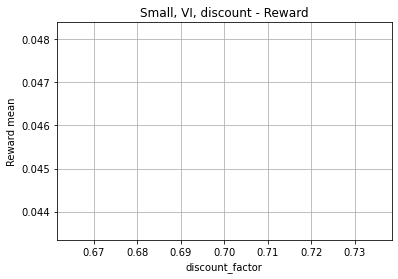

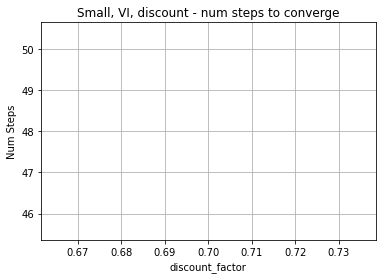

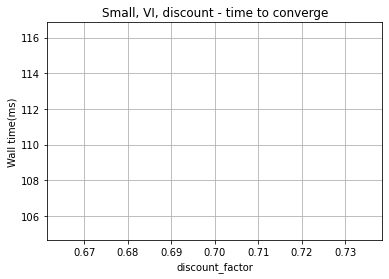

In [57]:
dfSweep['reward'].plot(ylabel="Reward mean", grid=True, title="Small, VI, discount - Reward"); plt.show()
dfSweep['n_steps'].plot(ylabel="Num Steps", grid=True, title="Small, VI, discount - num steps to converge"); plt.show()
(dfSweep['time']*1000).plot(ylabel="Wall time(ms)", grid=True, title="Small, VI, discount - time to converge"); plt.show()

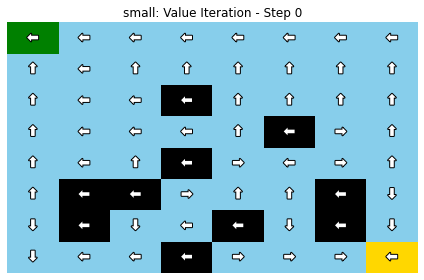

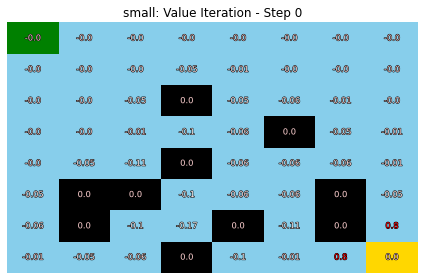

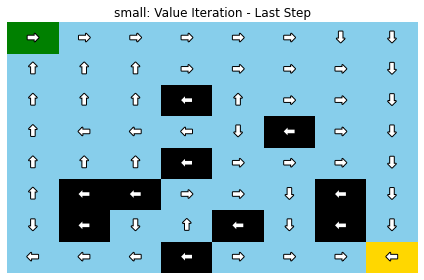

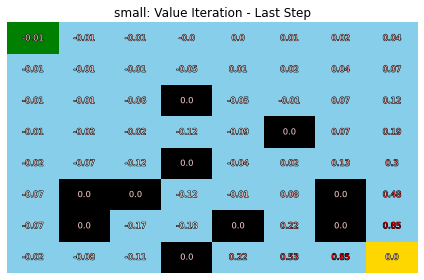

In [58]:
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Value Iteration', 'Step', "small", only_last=False)
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Value Iteration', 'Step', "small", only_last=True)

In [59]:
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, VI, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, VI, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, VI, Convergence"); plt.show()

### Policy Iteration

In [102]:
class PolicyIterationSolver(BaseSolver):
    def __init__(self, env, discount_factor=0.9, max_policy_eval_steps=None, verbose=False):
        self._env = env.unwrapped

        self._policy = np.ones([self._env.nS, self._env.nA]) / self._env.nA
        self._discount_factor = discount_factor
        self._steps = 0
        self._last_delta = 0
        self._step_times = []
        self._policy_stable = False
        self._max_policy_eval_steps = max_policy_eval_steps

        super(PolicyIterationSolver, self).__init__(verbose)

    def step(self):
        start_time = time.time()
        # Evaluate the current policy
        V = self.evaluate_policy(self._policy, discount_factor=self._discount_factor,
                                 max_steps=self._max_policy_eval_steps)

        # Will be set to false if we make any changes to the policy
        self._policy_stable = True

        delta = 0
        reward = 0  # float('-inf')
        # For each state...
        for s in range(self._env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(self._policy[s])

            # Find the best action by one-step lookahead
            # Ties are resolved arbitrarily
            action_values = one_step_lookahead(self._env, self._discount_factor, s, V)
            best_a = np.argmax(action_values)
            best_action_value = np.max(action_values)

            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # reward = max(reward, best_action_value)
            reward += best_action_value

            # Greedily update the policy
            if chosen_a != best_a:
                self._policy_stable = False
            self._policy[s] = np.eye(self._env.nA)[best_a]

        # If we've gone through a few steps but have not improved, consider us converged
        if delta > self._last_delta and self._steps > 10:
            self._policy_stable = True

        self._steps += 1
        self._step_times.append(time.time() - start_time)
        self._last_delta = delta

        return self._policy, V, self._steps, self._step_times[-1], reward, delta, self._policy_stable

    def reset(self):
        self._policy = np.ones([self._env.nS, self._env.nA]) / self._env.nA
        self._steps = 0
        self._step_times = []
        self._last_delta = 0
        self._policy_stable = False

    def has_converged(self):
        return self._policy_stable

    def get_convergence(self):
        return self._last_delta

    def run_until_converged(self):
        while not self.has_converged():
            self.step()

    def get_environment(self):
        return self._env

In [108]:
discount_factor_sweep = {}
# for discount_factor in [8]:
for discount_factor in range(1, 10):
    discount_factor /= 10.0
    print('discount_factor', discount_factor)

    solver = PolicyIterationSolver(env, discount_factor=discount_factor, max_policy_eval_steps=3000)
    exp_stats = ExperimentStats()

    t = time.time()
    step_count = 0
    optimal_policy = None
    best_reward = float('-inf')
    env.seed(SEED)
    while not solver.has_converged() and step_count < MAX_STEP_COUNT:
        policy, v, steps, step_time, reward, delta, converged = solver.step()
        if reward > best_reward:
            best_reward = reward
            optimal_policy = policy

        exp_stats.add(copy.deepcopy(policy), copy.deepcopy(v), steps, step_time, reward, delta, converged)
    #     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
        step_count += 1
#     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
    exp_stats.elapsed_time = time.time() - t
    exp_stats.optimal_policy = exp_stats.policies[-1]  # optimal_policy

    print("Took {} steps, {} time".format(step_count, exp_stats.elapsed_time))

    env.seed(SEED)
    eval_stats = EvaluationStats()
    for i in range(100):
        eval_stats.add(np.mean(solver.run_policy(exp_stats.optimal_policy)))
    eval_stats.compute()

    print('reward_mean', eval_stats.reward_mean)
    discount_factor_sweep[discount_factor] = {'reward': eval_stats.reward_mean, 'time': exp_stats.elapsed_time, 'n_steps': step_count}

discount_factor 0.1
Took 4 steps, 0.03275632858276367 time
reward_mean -0.004226363636363639
discount_factor 0.2
Took 5 steps, 0.0370938777923584 time
reward_mean -0.0039837012987013025
discount_factor 0.3
Took 5 steps, 0.04323077201843262 time
reward_mean -0.003988325581395352
discount_factor 0.4
Took 1000 steps, 9.932081937789917 time
reward_mean -0.0037442282690017975
discount_factor 0.5
Took 6 steps, 0.06747174263000488 time
reward_mean -0.0031624647219968176
discount_factor 0.6
Took 10 steps, 0.13371896743774414 time
reward_mean 0.037622263195832596
discount_factor 0.7
Took 8 steps, 0.12687182426452637 time
reward_mean 0.04804260630034727
discount_factor 0.8
Took 7 steps, 0.1630551815032959 time
reward_mean 0.04382087892887836
discount_factor 0.9
Took 6 steps, 0.2732832431793213 time
reward_mean 0.040431823832015185


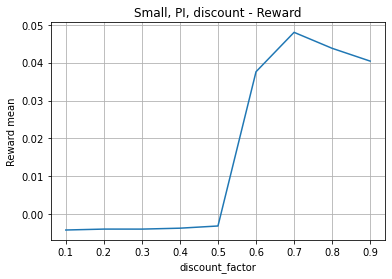

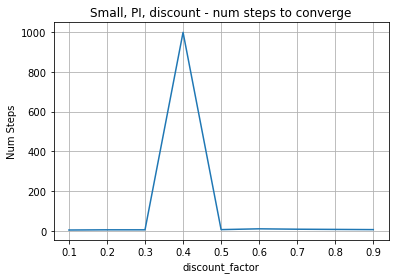

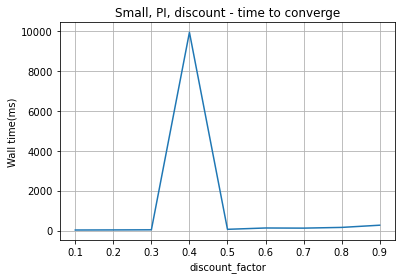

In [110]:
dfSweep = DataFrame(discount_factor_sweep).T
dfSweep.index.name = 'discount_factor'
dfSweep['n_steps'] = dfSweep['n_steps'].astype(int)
dfSweep['reward'].plot(ylabel="Reward mean", grid=True, title="Small, PI, discount - Reward"); plt.show()
dfSweep['n_steps'].plot(ylabel="Num Steps", grid=True, title="Small, PI, discount - num steps to converge"); plt.show()
(dfSweep['time']*1000).plot(ylabel="Wall time(ms)", grid=True, title="Small, PI, discount - time to converge"); plt.show()

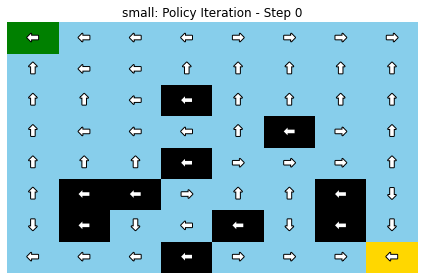

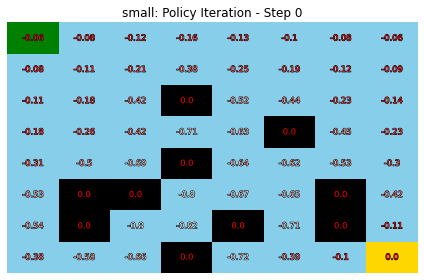

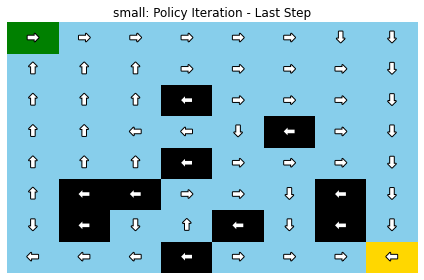

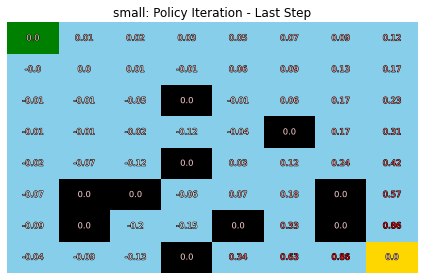

In [103]:
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Policy Iteration', 'Step', "small", only_last=False)
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Policy Iteration', 'Step', "small", only_last=True)

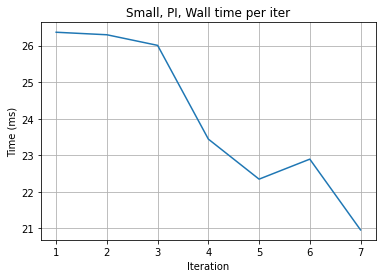

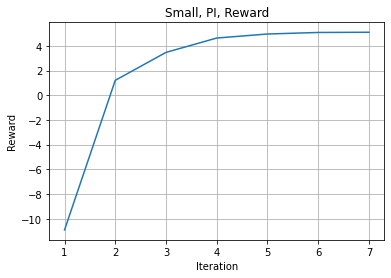

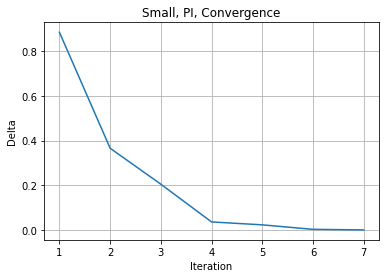

In [104]:
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, PI, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, PI, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, PI, Convergence"); plt.show()

### Q Learning

In [115]:
class QLearningSolver(BaseSolver):
    def __init__(self, env, max_episodes, max_steps_per_episode=500, discount_factor=1.0, alpha=0.5, epsilon=0.1,
                 epsilon_decay=0.001, q_init=0, theta=0.0001, min_consecutive_sub_theta_episodes=10, verbose=False):
        self._env = env.unwrapped

        self._max_episodes = max_episodes
        # Require we run for at least 5% of the max number of episodes
        self._min_episodes = np.floor(max_episodes * 0.1)
        self._max_steps_per_episode = max_steps_per_episode
        self._epsilon = epsilon
        self._initial_epsilon = epsilon
        self._epsilon_decay = epsilon_decay
        self._alpha = alpha
        self._discount_factor = discount_factor
        self._q_init = q_init
        self._steps = 0
        self._step_times = []
        self._last_delta = 0
        self._theta = theta
        self._stats = EpisodeStats(max_episodes)

        # We want to wait for a few consecutive episodes to be below theta before we consider the model converged
        self._consecutive_sub_theta_episodes = 0
        self._min_consecutive_sub_theta_episodes = min_consecutive_sub_theta_episodes

        self._init_q()

        super(QLearningSolver, self).__init__(verbose)

    def step(self):
        start_time = time.time()

        # Reset the environment and pick the first action
        state = self._env.reset()

        # One step in the environment
        total_reward = 0.0
        episode_steps = 0
        for t in range(self._max_steps_per_episode+1):
            # Take a step
            action_probs = self._policy_function(state)
            # TODO: Which one?
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = self._env.step(action)

            # Update statistics
            self._stats.episode_rewards[self._steps] += reward
            self._stats.episode_lengths[self._steps] = t
            self._stats.episode_times[self._steps] = time.time() - start_time

            # TD Update
            best_next_action = np.argmax(self._Q[next_state])
            td_target = reward + self._discount_factor * self._Q[next_state, best_next_action]
            td_delta = td_target - self._Q[state, action]
            self._stats.episode_deltas[self._steps] = td_delta
            self._Q[state, action] += self._alpha * td_delta

            # Decay epsilon
            self._epsilon -= self._epsilon * self._epsilon_decay

            total_reward += reward
            self._last_delta = max(self._last_delta, abs(td_delta))

            episode_steps += 1
            if done:
                break

            state = next_state

        if self._last_delta < self._theta:
            self._consecutive_sub_theta_episodes += 1
        else:
            self._consecutive_sub_theta_episodes = 0

        self._step_times.append(time.time() - start_time)

        self._steps += 1

        return self.get_policy(), self.get_value(), self._steps, self._step_times[-1], \
            total_reward/episode_steps, self._last_delta, self.has_converged()

    def reset(self):
        self._init_q()
        self._steps = 0
        self._step_times = []
        self._last_delta = 0
        self._epsilon = self._initial_epsilon
        self._stats = EpisodeStats(self._max_episodes)
        self._consecutive_sub_theta_episodes = 0

    def has_converged(self):
        return (self._steps >= self._min_episodes and
                self._consecutive_sub_theta_episodes >= self._min_consecutive_sub_theta_episodes) \
               or self._steps > self._max_episodes

    def get_convergence(self):
        return self._last_delta

    def run_until_converged(self):
        while not self.has_converged():
            self.step()

    def get_environment(self):
        return self._env

    def get_stats(self):
        return self._stats

    def get_q(self):
        return self._Q

    def get_policy(self):
        policy = np.zeros([self._env.nS, self._env.nA])
        for s in range(self._env.nS):
            best_action = np.argmax(self._Q[s])
            # Always take the best action
            policy[s, best_action] = 1.0

        return policy

    def get_value(self):
        v = np.zeros(self._env.nS)
        for s in range(self._env.nS):
            v[s] = np.max(self._Q[s])

        return v

    def _init_q(self):
        if self._q_init == 'random':
            self._Q = np.random.rand(self._env.observation_space.n, self._env.action_space.n)/1000.0
        elif int(self._q_init) == 0:
            self._Q = np.zeros(shape=(self._env.observation_space.n, self._env.action_space.n))
        else:
            self._Q = np.full((self._env.observation_space.n, self._env.action_space.n), float(self._q_init))

    def _policy_function(self, observation):
        A = np.ones(self._env.action_space.n, dtype=float) * self._epsilon / self._env.action_space.n
        best_action = np.argmax(self._Q[observation])
        A[best_action] += (1.0 - self._epsilon)
        return A

    # Adapted from https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb
    def _make_epsilon_greedy_policy(self):
        """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.

        Args:
            Q: A dictionary that maps from state -> action-values.
                Each value is a numpy array of length nA (see below)
            epsilon: The probability to select a random action . float between 0 and 1.
            nA: Number of actions in the environment.

        Returns:
            A function that takes the observation as an argument and returns
            the probabilities for each action in the form of a numpy array of length nA.

        """
        def policy_fn(observation):
            A = np.ones(self._env.action_space.n, dtype=float) * self._epsilon / self._env.action_space.n
            best_action = np.argmax(self._Q[observation])
            A[best_action] += (1.0 - self._epsilon)
            return A
        return policy_fn

In [232]:
class QLearningSolver(BaseSolver):
    def __init__(self, env, max_episodes, max_steps_per_episode=500, discount_factor=1.0, alpha=0.5, epsilon=0.1,
                 epsilon_decay=0.001, q_init=0, theta=0.0001, min_consecutive_sub_theta_episodes=10, verbose=False):
        self._env = env.unwrapped

        self._max_episodes = max_episodes
        # Require we run for at least 5% of the max number of episodes
        self._min_episodes = np.floor(max_episodes * 0.1)
        self._max_steps_per_episode = max_steps_per_episode
        self._epsilon = epsilon
        self._initial_epsilon = epsilon
        self._epsilon_decay = epsilon_decay
        self._alpha = alpha
        self._initial_alpha = alpha
        self._discount_factor = discount_factor
        self._q_init = q_init
        self._steps = 0
        self._step_times = []
        self._last_delta = 0
        self._theta = theta
        self._stats = EpisodeStats(max_episodes)

        # We want to wait for a few consecutive episodes to be below theta before we consider the model converged
        self._consecutive_sub_theta_episodes = 0
        self._min_consecutive_sub_theta_episodes = min_consecutive_sub_theta_episodes

        self._init_q()

        super(QLearningSolver, self).__init__(verbose)

    def step(self):
        start_time = time.time()

        # Reset the environment and pick the first action
        state = self._env.reset()

        # One step in the environment
        total_reward = 0.0
        episode_steps = 0
        for t in range(self._max_steps_per_episode+1):
            # Take a step
            action_probs = self._policy_function(state)
            # TODO: Which one?
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = self._env.step(action)

            # Update statistics
            self._stats.episode_rewards[self._steps] += reward
            self._stats.episode_lengths[self._steps] = t
            self._stats.episode_times[self._steps] = time.time() - start_time

            # TD Update
            best_next_action = np.argmax(self._Q[next_state])
            td_target = reward + self._discount_factor * self._Q[next_state, best_next_action]
            td_delta = td_target - self._Q[state, action]
            self._stats.episode_deltas[self._steps] = td_delta
            self._Q[state, action] += self._alpha * td_delta

            # Decay epsilon
            self._epsilon -= self._epsilon * self._epsilon_decay

            # Decay alpha
            self._alpha = max(0.05, self._initial_alpha / (self._steps + 1)) 

            total_reward += reward
            self._last_delta = max(self._last_delta, abs(td_delta))

            episode_steps += 1
            if done:
                break

            state = next_state

        if self._last_delta < self._theta:
            self._consecutive_sub_theta_episodes += 1
        else:
            self._consecutive_sub_theta_episodes = 0

        self._step_times.append(time.time() - start_time)

        self._steps += 1

        return self.get_policy(), self.get_value(), self._steps, self._step_times[-1], \
            total_reward/episode_steps, self._last_delta, self.has_converged()

    def reset(self):
        self._init_q()
        self._steps = 0
        self._step_times = []
        self._last_delta = 0
        self._epsilon = self._initial_epsilon
        self._alpha = self._initial_alpha
        self._stats = EpisodeStats(self._max_episodes)
        self._consecutive_sub_theta_episodes = 0

    def has_converged(self):
        return (self._steps >= self._min_episodes and
                self._consecutive_sub_theta_episodes >= self._min_consecutive_sub_theta_episodes) \
               or self._steps > self._max_episodes

    def get_convergence(self):
        return self._last_delta

    def run_until_converged(self):
        while not self.has_converged():
            self.step()

    def get_environment(self):
        return self._env

    def get_stats(self):
        return self._stats

    def get_q(self):
        return self._Q

    def get_policy(self):
        policy = np.zeros([self._env.nS, self._env.nA])
        for s in range(self._env.nS):
            best_action = np.argmax(self._Q[s])
            # Always take the best action
            policy[s, best_action] = 1.0

        return policy

    def get_value(self):
        v = np.zeros(self._env.nS)
        for s in range(self._env.nS):
            v[s] = np.max(self._Q[s])

        return v

    def _init_q(self):
        if self._q_init == 'random':
            self._Q = np.random.rand(self._env.observation_space.n, self._env.action_space.n)/1000.0
        elif int(self._q_init) == 0:
            self._Q = np.zeros(shape=(self._env.observation_space.n, self._env.action_space.n))
        else:
            self._Q = np.full((self._env.observation_space.n, self._env.action_space.n), float(self._q_init))

    def _policy_function(self, observation):
        A = np.ones(self._env.action_space.n, dtype=float) * self._epsilon / self._env.action_space.n
        best_action = np.argmax(self._Q[observation])
        A[best_action] += (1.0 - self._epsilon)
        return A

    # Adapted from https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb
    def _make_epsilon_greedy_policy(self):
        """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.

        Args:
            Q: A dictionary that maps from state -> action-values.
                Each value is a numpy array of length nA (see below)
            epsilon: The probability to select a random action . float between 0 and 1.
            nA: Number of actions in the environment.

        Returns:
            A function that takes the observation as an argument and returns
            the probabilities for each action in the form of a numpy array of length nA.

        """
        def policy_fn(observation):
            A = np.ones(self._env.action_space.n, dtype=float) * self._epsilon / self._env.action_space.n
            best_action = np.argmax(self._Q[observation])
            A[best_action] += (1.0 - self._epsilon)
            return A
        return policy_fn

In [249]:
env.reset()
# alphas = [0.1, 0.5, 0.9]
alphas = [0.1]
# q_inits = ['random', 0]
q_inits = [0]
# epsilons = [0.1, 0.3, 0.5]
epsilons = [0.7]
# epsilon_decays = [0.0001]
epsilon_decays = [0.0]
# discount_factors = np.round(np.linspace(0, 0.9, num=10), 2)
# discount_factors = [i/10.0 for i in range(1, 10)]
discount_factors = [0.8]
dims = len(discount_factors) * len(alphas) * len(q_inits) * len(epsilons) * len(epsilon_decays)
max_episodes = 1000
print("Searching Q in {} dimensions".format(dims))

Searching Q in 1 dimensions


In [250]:
runs = 1
param_sweep = {}
for alpha in alphas:
    for q_init in q_inits:
        for epsilon in epsilons:
            for epsilon_decay in epsilon_decays:
                for discount_factor in discount_factors:
                    t = time.time()
                    print("{}/{} Processing Q with alpha {}, q_init {}, epsilon {}, epsilon_decay {},"
                             " discount_factor {}".format(
                        runs, dims, alpha, q_init, epsilon, epsilon_decay, discount_factor
                    ))
                    runs += 1
                    
                    solver = QLearningSolver(env, max_episodes, discount_factor=discount_factor, alpha=alpha, epsilon=epsilon, epsilon_decay=epsilon_decay, q_init=q_init)
                    exp_stats = ExperimentStats()
                    
                    t = time.time()
                    step_count = 0
                    optimal_policy = None
                    best_reward = float('-inf')
                    env.seed(SEED)
                    while not solver.has_converged() and step_count < MAX_STEP_COUNT:
                        policy, v, steps, step_time, reward, delta, converged = solver.step()
                        if reward > best_reward:
                            best_reward = reward
                            optimal_policy = policy

                        exp_stats.add(copy.deepcopy(policy), copy.deepcopy(v), steps, step_time, reward, delta, converged)
                    #     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
                        step_count += 1
                    print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
                    exp_stats.elapsed_time = time.time() - t
                    exp_stats.optimal_policy = exp_stats.policies[-1]  # optimal_policy
                    episode_stats = solver.get_stats()
                    
                    print("Took {} steps, {} time".format(step_count, exp_stats.elapsed_time))

                    env.seed(SEED)
                    eval_stats = EvaluationStats()
                    for i in range(100):
                        eval_stats.add(np.mean(solver.run_policy(exp_stats.optimal_policy)))
                    eval_stats.compute()

                    print('reward_mean', eval_stats.reward_mean)
                    param_sweep[discount_factor] = {'reward': eval_stats.reward_mean, 'time': exp_stats.elapsed_time, 'n_steps': step_count}                    
                    
#                     break
                else:
                    continue
                break
            else:
                continue
            break
        else:
            continue
        break
    else:
        continue
    break

1/1 Processing Q with alpha 0.1, q_init 0, epsilon 0.7, epsilon_decay 0.0, discount_factor 0.8
Step 1000: delta=1.7922454820736373, converged=False, reward=-0.0538, best_reward=0.04884210526315789
Took 1000 steps, 2.3627102375030518 time
reward_mean 0.03704285162958201


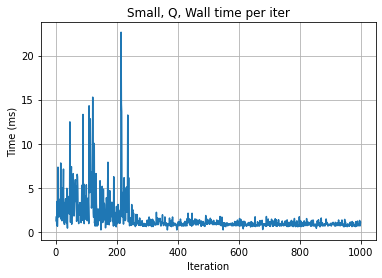

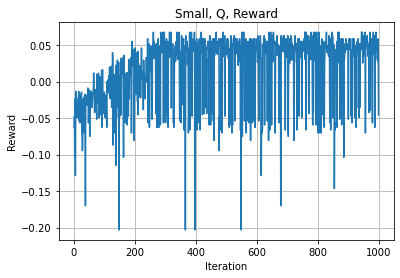

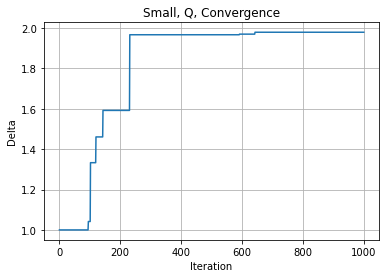

In [242]:
# e 0.1
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, Q, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, Q, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, Q, Convergence"); plt.show()

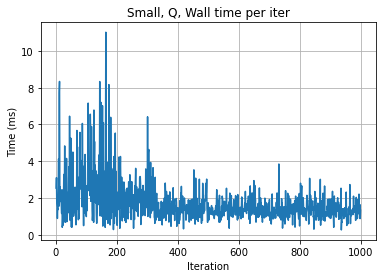

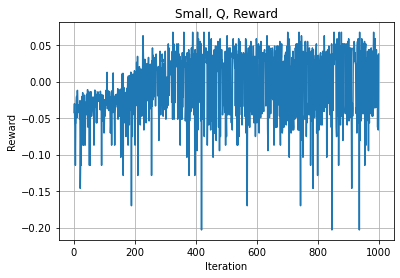

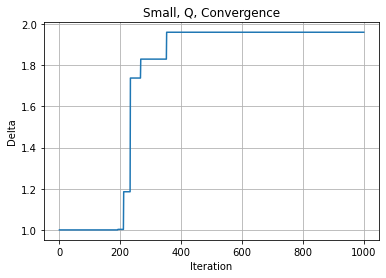

In [245]:
# e 0.3
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, Q, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, Q, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, Q, Convergence"); plt.show()

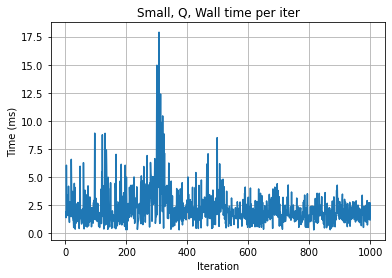

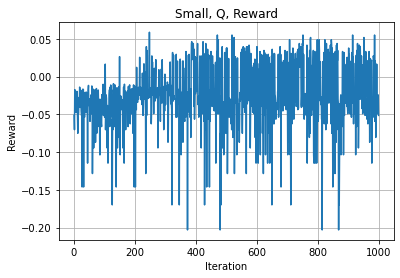

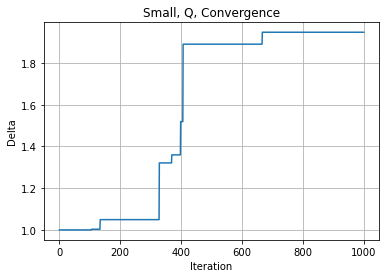

In [248]:
# e 0.5
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, Q, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, Q, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, Q, Convergence"); plt.show()

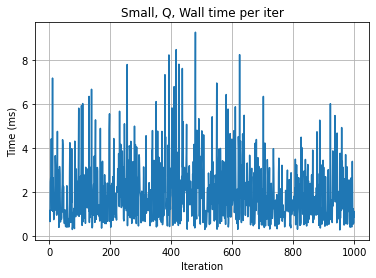

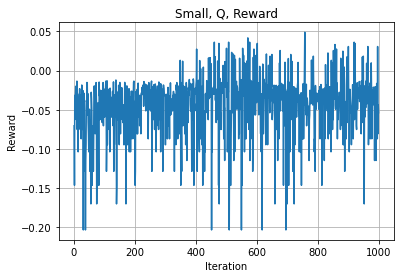

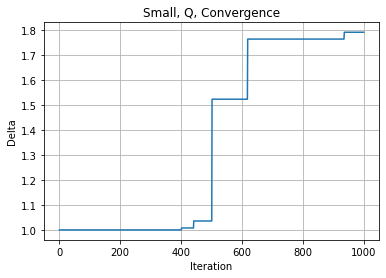

In [251]:
# e 0.7
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, Q, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, Q, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, Q, Convergence"); plt.show()

In [190]:
runs = 1
param_sweep = {}
for alpha in alphas:
    for q_init in q_inits:
        for epsilon in epsilons:
            for epsilon_decay in epsilon_decays:
                for discount_factor in discount_factors:
                    t = time.time()
                    print("{}/{} Processing Q with alpha {}, q_init {}, epsilon {}, epsilon_decay {},"
                             " discount_factor {}".format(
                        runs, dims, alpha, q_init, epsilon, epsilon_decay, discount_factor
                    ))
                    runs += 1
                    
                    solver = QLearningSolver(env, max_episodes, discount_factor=discount_factor, alpha=alpha, epsilon=epsilon, epsilon_decay=epsilon_decay, q_init=q_init)
                    exp_stats = ExperimentStats()
                    
                    t = time.time()
                    step_count = 0
                    optimal_policy = None
                    best_reward = float('-inf')
                    env.seed(SEED)
                    while not solver.has_converged() and step_count < MAX_STEP_COUNT:
                        policy, v, steps, step_time, reward, delta, converged = solver.step()
                        if reward > best_reward:
                            best_reward = reward
                            optimal_policy = policy

                        exp_stats.add(copy.deepcopy(policy), copy.deepcopy(v), steps, step_time, reward, delta, converged)
                    #     print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
                        step_count += 1
                    print("Step {}: delta={}, converged={}, reward={}, best_reward={}".format(step_count, delta, converged, reward, best_reward))
                    exp_stats.elapsed_time = time.time() - t
                    exp_stats.optimal_policy = exp_stats.policies[-1]  # optimal_policy
                    episode_stats = solver.get_stats()
                    
                    print("Took {} steps, {} time".format(step_count, exp_stats.elapsed_time))

                    env.seed(SEED)
                    eval_stats = EvaluationStats()
                    for i in range(100):
                        eval_stats.add(np.mean(solver.run_policy(exp_stats.optimal_policy)))
                    eval_stats.compute()

                    print('reward_mean', eval_stats.reward_mean)
                    param_sweep[discount_factor] = {'reward': eval_stats.reward_mean, 'time': exp_stats.elapsed_time, 'n_steps': step_count}                    
                    
#                     break
                else:
                    continue
                break
            else:
                continue
            break
        else:
            continue
        break
    else:
        continue
    break

1/1 Processing Q with alpha 0.1, q_init 0, epsilon 0.1, epsilon_decay 0.0001, discount_factor 0.8
Step 1000: delta=1.9875831652474787, converged=False, reward=0.0462, best_reward=0.06771428571428571
Took 1000 steps, 1.7946429252624512 time
reward_mean 0.03776211919161986


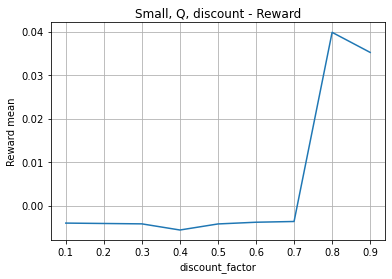

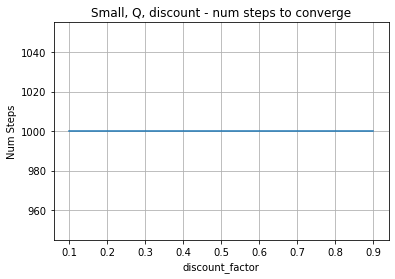

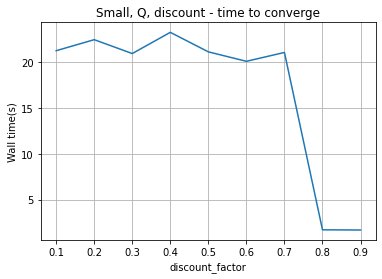

In [188]:
dfSweep = DataFrame(param_sweep).T
dfSweep.index.name = 'discount_factor'
dfSweep['n_steps'] = dfSweep['n_steps'].astype(int)
dfSweep['reward'].plot(ylabel="Reward mean", grid=True, title="Small, Q, discount - Reward"); plt.show()
dfSweep['n_steps'].plot(ylabel="Num Steps", grid=True, title="Small, Q, discount - num steps to converge"); plt.show()
(dfSweep['time']).plot(ylabel="Wall time(s)", grid=True, title="Small, Q, discount - time to converge"); plt.show()

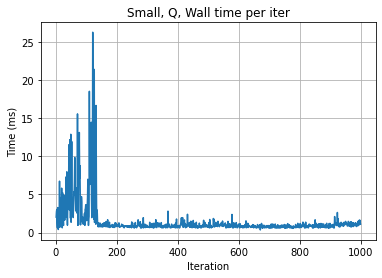

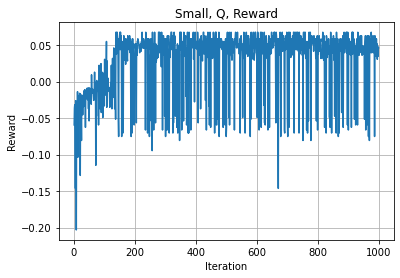

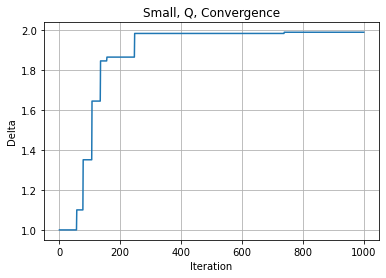

In [191]:
exp_stats.to_csv('stats.csv')
df = pd.read_csv('stats.csv')
df.set_index('steps', inplace=True)
(df['time']*1000).plot(xlabel='Iteration', ylabel="Time (ms)", grid=True, title="Small, Q, Wall time per iter"); plt.show()
(df['reward']).plot(xlabel='Iteration', ylabel="Reward", grid=True, title="Small, Q, Reward"); plt.show()
(df['delta']).plot(xlabel='Iteration', ylabel="Delta", grid=True, title="Small, Q, Convergence"); plt.show()

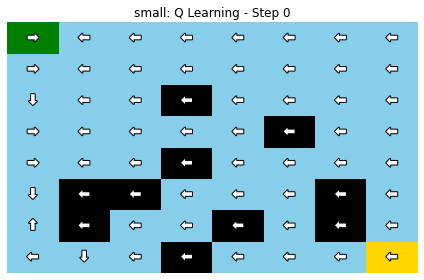

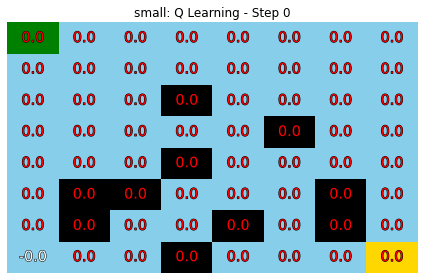

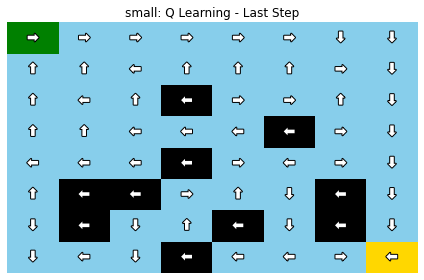

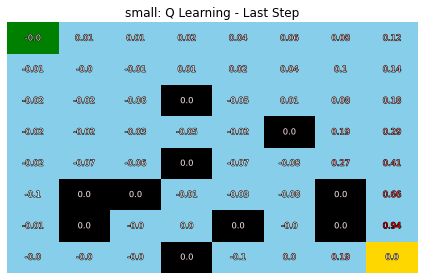

In [192]:
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Q Learning', 'Step', "small", only_last=False)
exp_stats.plot_policies_on_map('{}/images/VI/{}_{}_{}.png'.format("A4", "small", "0.5", '{}_{}'),
                           map_desc, env.colors(), env.directions(),
                           'Q Learning', 'Step', "small", only_last=True)